## Reranking an existing model

Can we improve on the existing LR model?

Ideally we'd first now how it's poor, then impose constraints to correct for that.

In [1]:
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LogisticRegression
import maxentropy
import maxentropy.utils as utils

import plotly.io as pio
pio.renderers.default = 'plotly_mimetype'

import plotly.express as px

from sklearn.datasets import load_iris, load_breast_cancer

iris = load_iris()
cancer = load_breast_cancer(as_frame=True)

## First example: find the model with minimum relative entropy to some prior model subject to a non-negativity constraint

In [2]:
cancer['feature_names']

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [3]:
X_cancer = cancer['data']
y_cancer = cancer['target']

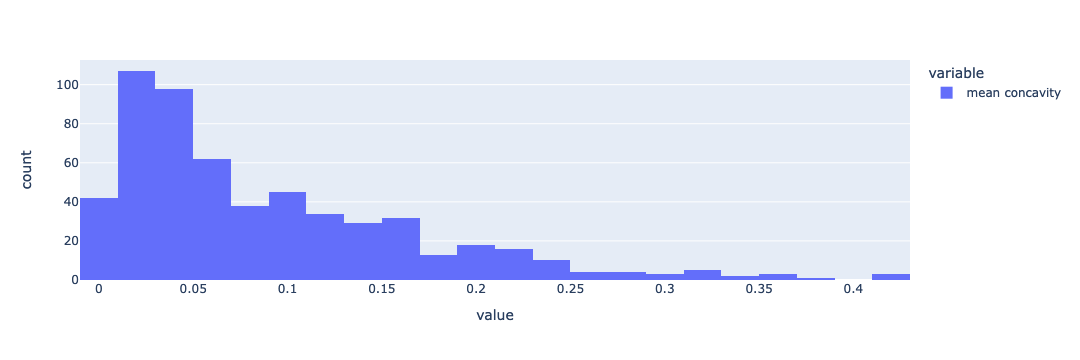

In [4]:
px.histogram(X_cancer['mean concavity'])

Suppose we fit this with a beta distribution:

In [5]:
prior_model_params = scipy.stats.norm.fit(X_cancer['mean concavity'])

In [6]:
prior_model = scipy.stats.norm(*prior_model_params)

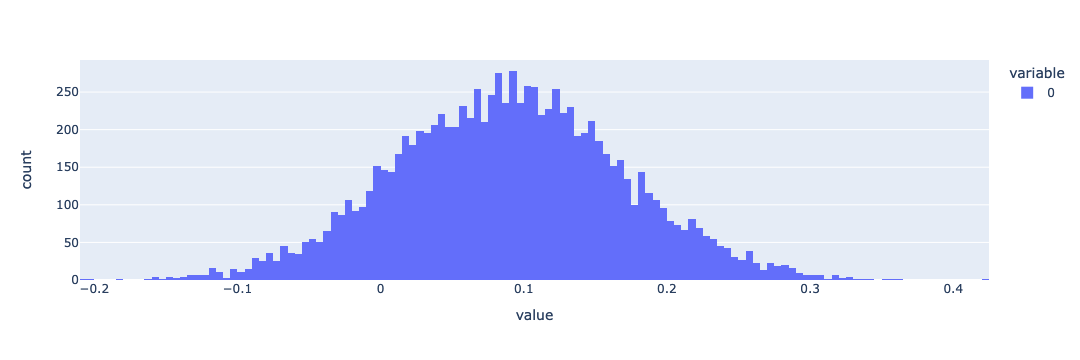

In [7]:
x = prior_model.rvs(10_000)
px.histogram(x)

In [8]:
prior_model.logpdf(x)

array([ 1.58452452,  1.6071965 ,  0.39386889, ..., -1.9274795 ,
        1.47429214,  0.76022152])

In [9]:
np.mean(x > 0)

0.8696

### Answer

In [10]:
def non_neg(x):
    return x >= 0

In [ ]:
auxiliary = scipy.stats.uniform(-0.2, 1.2)   # i.e. from -0.2 to 1.0

sampler = maxentropy.utils.auxiliary_sampler_scipy(auxiliary, n_samples=10_000)

In [14]:
next(sampler)[0]

array([[-0.16064919],
       [-0.09596532],
       [ 0.61829454],
       ...,
       [-0.10772471],
       [ 0.62616906],
       [ 0.033126  ]])

In [15]:
# features = []
# for col_num in range(X.shape[1]):
#     def generate_feature(col_num):
#         def f_col(X):
#             return X[:, col_num] >= 0
#         # def f_col_square(X):
#         #     return X[:, col_num]**2
#         # return f_col, f_col_square
#         return [f_col]
#     features += generate_feature(col_num)

In [16]:
# len(features)

In [17]:
# X.shape

Constrain each column's mean and variance:

In [18]:
# stretched_minima, stretched_maxima = utils.bounds_stretched(X_)
# uniform_dist = scipy.stats.uniform(
#     stretched_minima, stretched_maxima - stretched_minima
# )
# sampler = utils.auxiliary_sampler_scipy(
#     uniform_dist, n_dims=len(cancer["feature_names"]), n_samples=10_000
# )

In [19]:
model = maxentropy.SamplingMinKLDensity(
    [non_neg], sampler, prior_log_pdf = prior_model.logpdf, matrix_format='ndarray', 
)

In [20]:
model.params

array([0.])

In [21]:
# X_cancer['mean concavity'].values

In [22]:
# non_neg(X_cancer.values)

In [23]:
model.resetparams()

In [24]:
model.params

array([0.])

In [25]:
model.setparams([2.0])
# model.setparams([2.0, 1.0])

In [26]:
model.params

array([2.])

In [27]:
model.estimate()

In [28]:
model.mu

array([0.97918488])

In [29]:
model._logv()

array([ -1.57315121,  -1.17092693,  -3.55863021, ...,  -3.61960769,
         0.20870257, -30.46102921])

In [30]:
model.log_norm_constant()

1.894120120059469

In [31]:
model.feature_expectations()

array([0.97918488])

In [32]:
# X_cancer['mean concavity'].values.reshape(-1, 1)

In [33]:
X_cancer['mean concavity'].mean()

0.0887993158172232

In [34]:
k = model.features(np.array([X_cancer['mean concavity'].mean()]))

In [35]:
k

array([[1.]])

In [36]:
model.fit(k)

SamplingMinKLDensity(auxiliary_sampler=<generator object auxiliary_sampler_scipy at 0x17cf6f540>,
                     feature_functions=[<function non_neg at 0x17cf2f4c0>],
                     matrix_format='ndarray',
                     prior_log_pdf=<bound method rv_continuous_frozen.logpdf of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x17ce446d0>>)

In [63]:
model.feature_expectations()

array([1.])

#### Now plot the fitted model

In [ ]:
x = prior_model.rvs(10_000)

In [71]:
df = pd.DataFrame({'x': x, 'sampling': auxiliary.pdf(x), 'prior': prior_model.pdf(x), 'constrained': model.predict_proba(x)})
df

,x,sampling,prior,constrained
0,0.172373,0.833333,2.888395,3.279254
1,0.117807,0.833333,4.687328,5.321618
2,0.073700,0.833333,4.919508,5.585217
3,0.253323,0.833333,0.593239,0.673516
4,0.128667,0.833333,4.418986,5.016964
...,...,...,...,...
9995,0.062921,0.833333,4.751205,5.394138
9996,0.184461,0.833333,2.434973,2.764474
9997,0.032197,0.833333,3.891023,4.417557
9998,0.198016,0.833333,1.956309,2.221037


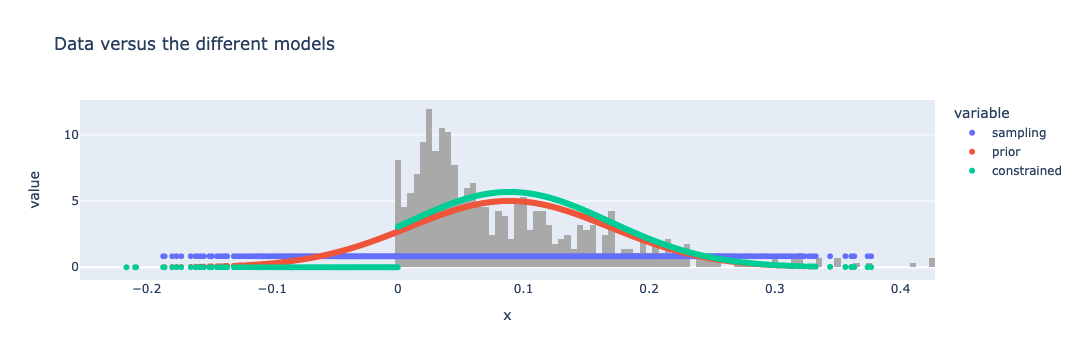

In [87]:
fig = px.scatter(df, x='x', y=['sampling', 'prior', 'constrained'], title='Data versus the different models')
fig2 = px.histogram(x=X_cancer['mean concavity'], histnorm='probability density', nbins=100, color_discrete_sequence=['darkgray'])
fig.add_traces(fig2.data)

## Question: what if the prior is not normalized? Does it matter?

In [90]:
const = 10.

In [91]:
def unnormalized_prior_logpdf(x):
    return prior_model.logpdf(x) + const

In [92]:
unnormalized_prior_logpdf(x)

array([11.06070115, 11.54486266, 11.59320858, ..., 11.35867208,
       10.67105957, 11.55872079])

In [19]:
model = maxentropy.SamplingMinKLDensity(
    [non_neg], sampler, prior_log_pdf = prior_model.logpdf, matrix_format='ndarray', 
)

In [93]:
model.fit(k)

SamplingMinKLDensity(auxiliary_sampler=<generator object auxiliary_sampler_scipy at 0x17cf6f540>,
                     feature_functions=[<function non_neg at 0x17cf2f4c0>],
                     matrix_format='ndarray',
                     prior_log_pdf=<bound method rv_continuous_frozen.logpdf of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x17ce446d0>>)

In [96]:
df = pd.DataFrame({
    'x': x,
    'sampling': auxiliary.pdf(x),
    'prior': np.exp(unnormalized_prior_logpdf(x)),
    'constrained': model.predict_proba(x)
})

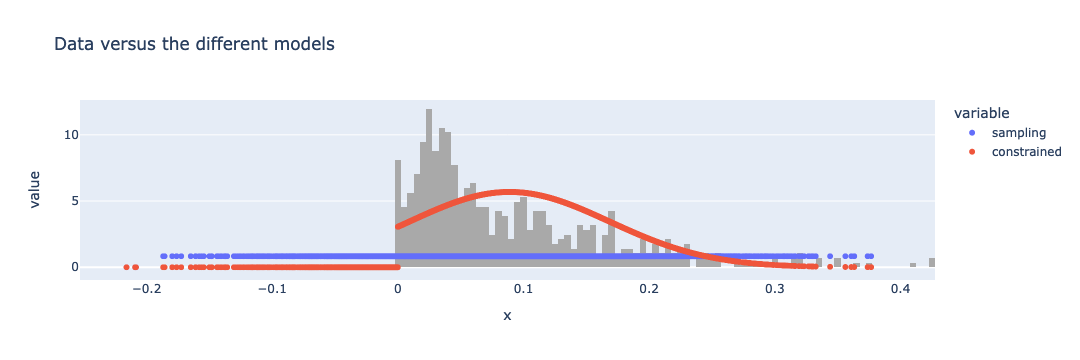

In [98]:
fig = px.scatter(df, x='x', y=['sampling', 'constrained'], title='Data versus the different models')
fig2 = px.histogram(x=X_cancer['mean concavity'], histnorm='probability density', nbins=100, color_discrete_sequence=['darkgray'])
fig.add_traces(fig2.data)

#### Answer: no! It doesn't matter if the prior probability density is unnormalized

### Question: Can we fit a neural network for classification, remove the final softmax layer, and then apply this?

In [99]:
from sklearn.neural_network import MLPClassifier

In [100]:
net = MLPClassifier(hidden_layer_sizes=(100,))

In [ ]:
net.fit(X_c

### Ideas for improving the usability

##### Current API

In [ ]:
def non_neg(x):
    return x >= 0

prior_model_params = scipy.stats.norm.fit(X_cancer['mean concavity'])

auxiliary = scipy.stats.uniform(-0.2, 1.2)   # i.e. from -0.2 to 1.0

sampler = maxentropy.utils.auxiliary_sampler_scipy(auxiliary, n_samples=10_000)

model = maxentropy.SamplingMinKLDensity(
    [non_neg], sampler, prior_log_pdf = prior_model.logpdf, matrix_format='ndarray', 
)

k = model.features(np.array([X_cancer['mean concavity'].mean()]))

model.fit(k)

##### Desired API

In [ ]:
model = maxentropy.SamplingMinKLDensity(sampler='uniform', matrix_format='ndarray', sampling_stretch_factor=0.1, n_samples=10_000)

In [ ]:
feature_functions = [non_neg] * X_cancer.shape[1]

model.fit(X_cancer, feature_functions=feature_functions)

In [ ]:
def non_neg(x):
    return x >= 0